In [93]:
import requests

from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import re

import os
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from IPython.display import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [42]:
filename = "data//data2020-05-30"
df = pd.read_csv(filename + 'cleaned.csv')

In [43]:
df.head()

,Year,Name,Placement,Acronym,cleanedPlacement,university,place,usnews,Academia,Rank
0,2019,<p>Yahia Abuhashem,Anthem,american,anthem,American University,"Washington, DC",RNP in Economics,False,80
1,2019,Zidong An,International Monetary Fund,american,international monetary fund,American University,"Washington, DC",RNP in Economics,False,80
2,2019,James Boohaker,US Government Accountability Office,american,us government accountability office,American University,"Washington, DC",RNP in Economics,False,80
3,2019,Woubet Kassa,World Bank,american,world bank,American University,"Washington, DC",RNP in Economics,False,80
4,2019,Natalia Leszczyszyn,Environmental Protection Agency,american,environmental protection agency,American University,"Washington, DC",RNP in Economics,False,80


## Overview



In [120]:
# Create bins of different rank universities
conditions = [
    (df['Rank'] <= 30),
    (df['Rank'] > 30) & (df['Rank'] <= 60)]
choices = ['1-30', '31-60']
df['Rank_cat'] = np.select(conditions, choices, default = '61-100')

df['Academia'] = np.where(df['Academia'], 'Academics', 'non-Academics')

In [71]:
# PhD counts by year
group_by_year = df.groupby('Year').agg(freq = ('Year', 'count')).reset_index()
# PhD counts by year and rank categories
group_by_year_rankcat = df.groupby(['Year', 'Rank_cat']).size().reset_index(name = 'freq')
# PhD counts by rank categories
group_by_rankcat_ind = df.groupby(['Rank_cat']).size().reset_index(name = 'freq')
# Counts of univs by rank categories
group_by_rankcat_univ = df.groupby(['Rank_cat', 'Acronym']).size().reset_index(name = 'freq')
group_by_rankcat_univ = group_by_rankcat_univ.groupby(['Rank_cat']).size().reset_index(name = 'freq')

Below charts show the number of graduating Phds by year. There are mainly two key takeaways:

1. The number of Phds is increasing year by year

2. Our sample focuses more on the top 30 schools

In [76]:
fig = make_subplots(
    rows = 2, cols = 2,
    specs=[[{}, {"type": "Bar"}],
           [{}, {"type": "Bar"}]],
    subplot_titles=("Total PhD counts by year","Total PhD counts by year and ranks", 
                    "Number of PhDs by rank", "Number of univs by rank"))

trace1 = px.line(group_by_year_rankcat, x = "Year", y = "freq", color = 'Rank_cat')['data'][0:3]

fig.add_trace(go.Scatter(x = group_by_year["Year"], y = group_by_year["freq"], 
                         mode = 'lines', line = dict(width=0.5, color = 'black'), name = "Total PhD counts"), 1, 1)
fig.add_trace(trace1[0], 1, 2).add_trace(trace1[1], 1, 2).add_trace(trace1[2], 1, 2)
fig.add_trace(go.Bar(x = list(group_by_rankcat_ind['Rank_cat']), y = list(group_by_rankcat_ind['freq']), 
                     text = group_by_rankcat_ind['Rank_cat'], name = "PhD counts by rank"), 2, 1)
fig.add_trace(go.Bar(x = list(group_by_rankcat_univ['Rank_cat']), y = list(group_by_rankcat_univ['freq']), 
                     text = group_by_rankcat_univ['Rank_cat'], name = "Univ counts by rank"), 2, 2)

fig.show()

The wordcloud summarizes the most popular employers.

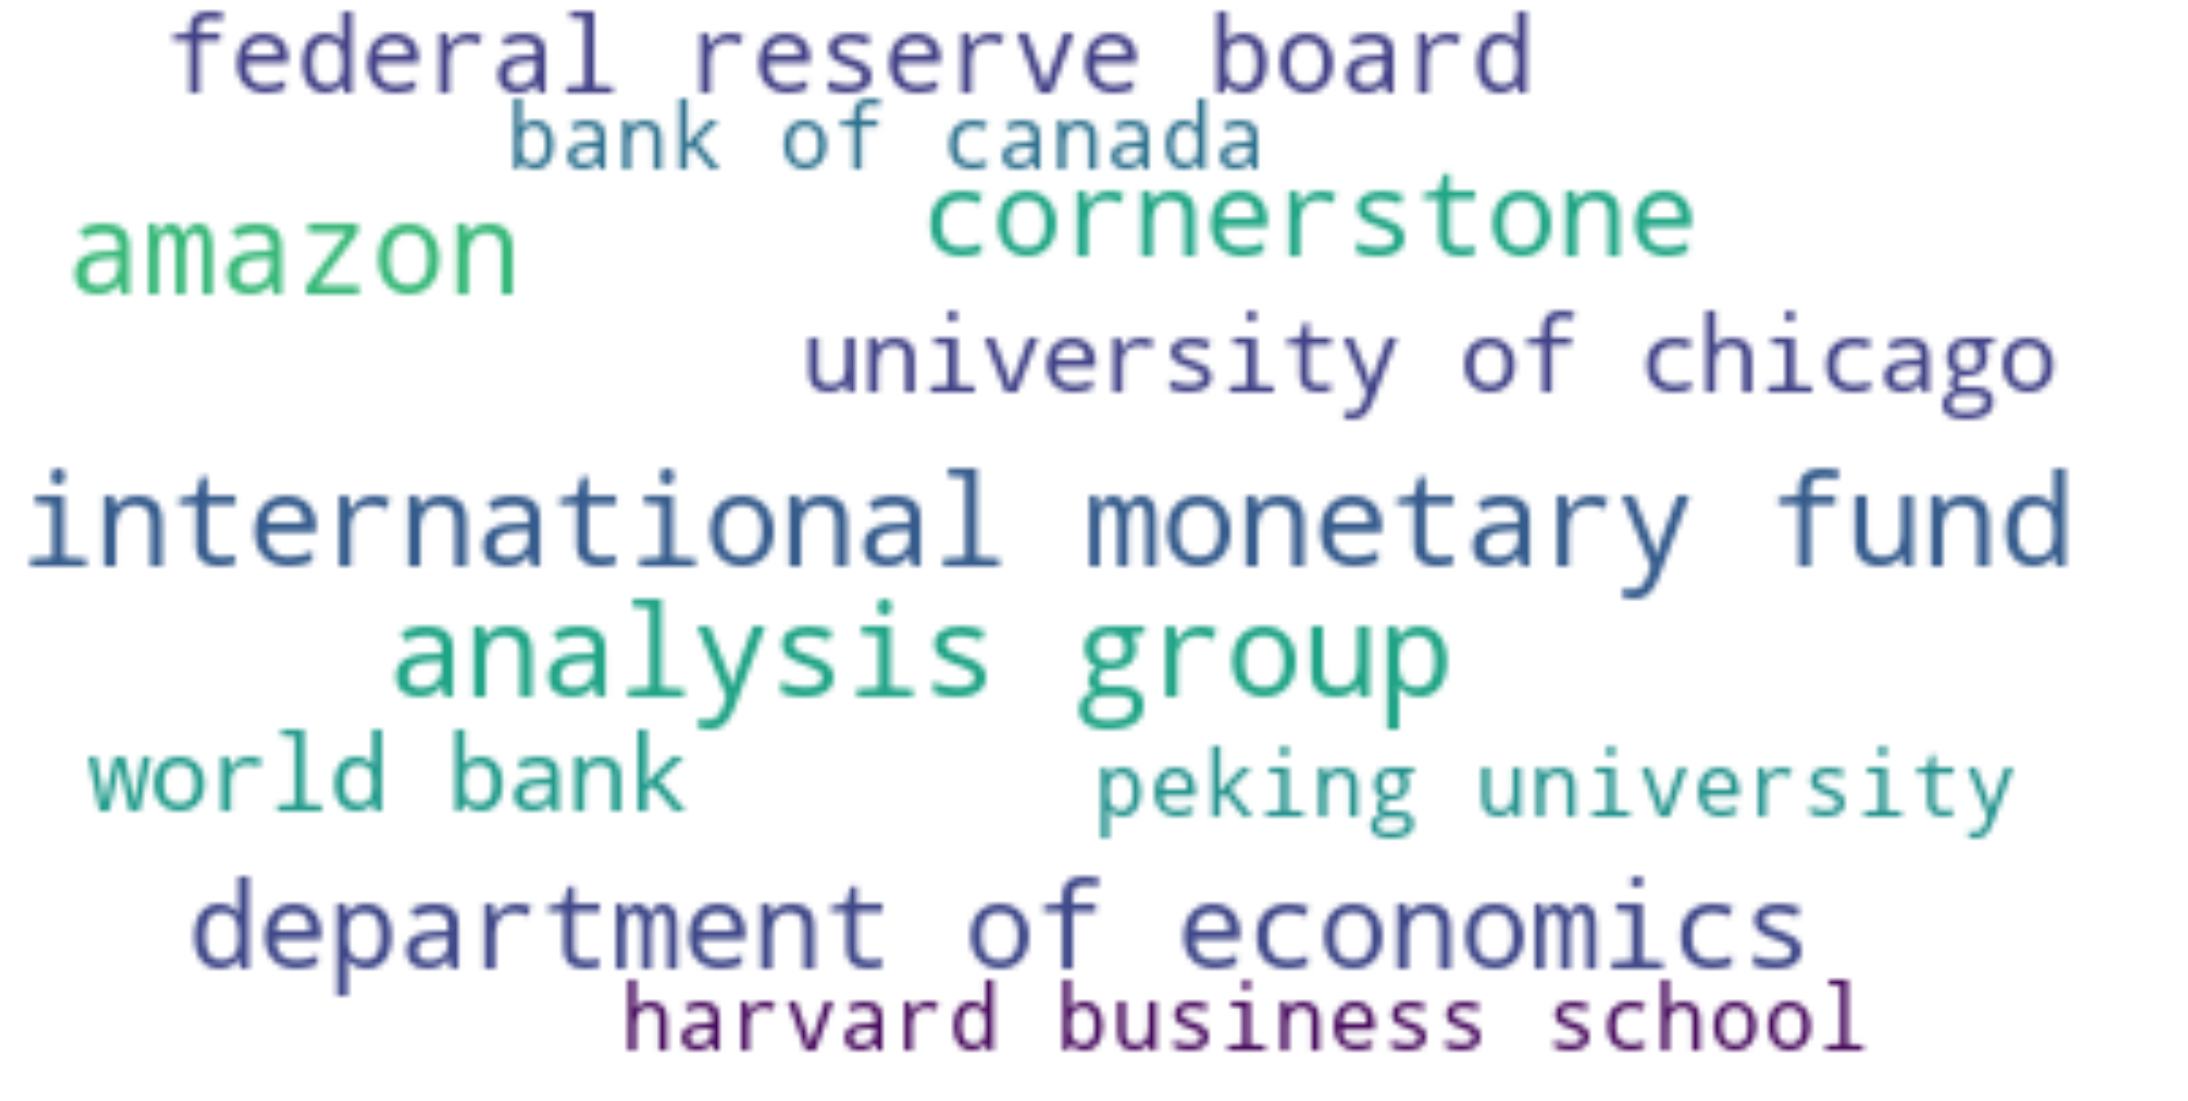

In [102]:
# keep top hire
group_by_plm = df.groupby('cleanedPlacement').size().reset_index(name = 'freq').sort_values(by = 'freq', ascending=False)
top_hire = group_by_plm.iloc[0:11,]
d = {}

for i in range(len(top_hire)):
    d[top_hire.iloc[i, 0]] = top_hire.iloc[i, 1]

# generate teh word cloud
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies = d)
plt.figure(figsize=(40,20))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

## Academia vs non-Academia

In [123]:
# PhD counts by year and Academia
group_by_year_acad = df.groupby(['Year', 'Academia']).agg(freq_acad = ('Year', 'count')).reset_index()
group_by_year_acad = pd.merge(group_by_year_acad, group_by_year, 'left', 'Year')
group_by_year_acad['fraction'] = group_by_year_acad['freq_acad']/group_by_year_acad['freq'] * 100
group_by_year_acad = group_by_year_acad[group_by_year_acad['Year'] >= 2010]

# PhD counts by year and Academia and rank
group_by_year_rankcat_acad = df.groupby(['Year', 'Rank_cat', 'Academia']).size().reset_index(name = 'freq_acad')
group_by_year_rankcat_acad = pd.merge(group_by_year_rankcat_acad, group_by_year_rankcat, 'left', ['Year', 'Rank_cat'])
group_by_year_rankcat_acad['fraction'] = group_by_year_rankcat_acad['freq_acad']/group_by_year_rankcat_acad['freq'] * 100
group_by_year_rankcat_acad = group_by_year_rankcat_acad[group_by_year_rankcat_acad['Year'] >= 2010]

rank_acad_30 = group_by_year_rankcat_acad[group_by_year_rankcat_acad['Rank_cat'] == '1-30']
rank_acad_60 = group_by_year_rankcat_acad[group_by_year_rankcat_acad['Rank_cat'] == '31-60']
rank_acad_100 = group_by_year_rankcat_acad[group_by_year_rankcat_acad['Rank_cat'] == '61-100']

Overall the non-academics fraction is surpassing the academics fraction. In top 30 and 60-100 schools, the fraction is roughly 60 percent in recent years.

In [130]:
fig = make_subplots(
    rows = 2, cols = 3,
    specs=[[{"colspan": 3}, None, None],
           [{}, {}, {}]],
    subplot_titles=("Academics vs non-Academics","Top 30", 
                    "Rank 30-60", "Rank 60-100"))

trace1 = px.line(group_by_year_acad, x = "Year", y = "fraction", color = 'Academia')['data'][0:2]
fig.add_trace(trace1[0], 1, 1).add_trace(trace1[1], 1, 1)
trace1 = px.line(rank_acad_30, x = "Year", y = "fraction", color = 'Academia')['data'][0:2]
fig.add_trace(trace1[0], 2, 1).add_trace(trace1[1], 2, 1)
trace1 = px.line(rank_acad_60, x = "Year", y = "fraction", color = 'Academia')['data'][0:2]
fig.add_trace(trace1[0], 2, 2).add_trace(trace1[1], 2, 2)
trace1 = px.line(rank_acad_100, x = "Year", y = "fraction", color = 'Academia')['data'][0:2]
fig.add_trace(trace1[0], 2, 3).add_trace(trace1[1], 2, 3)

fig.update_layout(
    autosize = False,
    width = 800,
    height = 600)
fig.show()

## Employee dynamics

In [157]:
def plot_employer(employer):
    
    emp = df[df['cleanedPlacement'] == employer]
    group_by_year_acr = emp.groupby(['Year', 'Acronym']).size().reset_index(name = 'freq')
    fig = px.bar(group_by_year_acr, x = "Year", y = "freq", color = 'Acronym', title = 'Employment dynamics of ' + employer)
    fig.show()

    group_by_acr = emp.groupby(['Acronym']).size().reset_index(name = 'freq')
    fig = px.pie(group_by_acr, values = 'freq', names = 'Acronym', title = 'Employment dist of ' + employer)
    fig.show()
    
    return(None)

Universities most likely hired by Amazon and IMF:

In [158]:
employer = 'amazon'
plot_employer(employer)

In [159]:
employer = 'international monetary fund'
plot_employee(employer)